
--- Hypothesis Testing Results ---
B_min      B          B/B_min    Var(Est)     Threshold    Decision   Correct   
0.20       0.00       0.00       0.00000      0.00100      H0         True      
0.20       0.05       0.25       0.00015      0.00100      H0         False     
0.20       0.10       0.50       0.00063      0.00100      H0         False     
0.20       0.20       1.00       0.00248      0.00100      H1         True      
0.20       0.30       1.50       0.00524      0.00100      H1         True      
0.20       0.40       2.00       0.00836      0.00100      H1         True      
0.20       0.50       2.50       0.01119      0.00100      H1         True      
0.20       0.60       3.00       0.01305      0.00100      H1         True      
0.40       0.00       0.00       0.00000      0.00100      H0         True      
0.40       0.10       0.25       0.00063      0.00100      H0         False     
0.40       0.20       0.50       0.00248      0.00100      H1         Fal

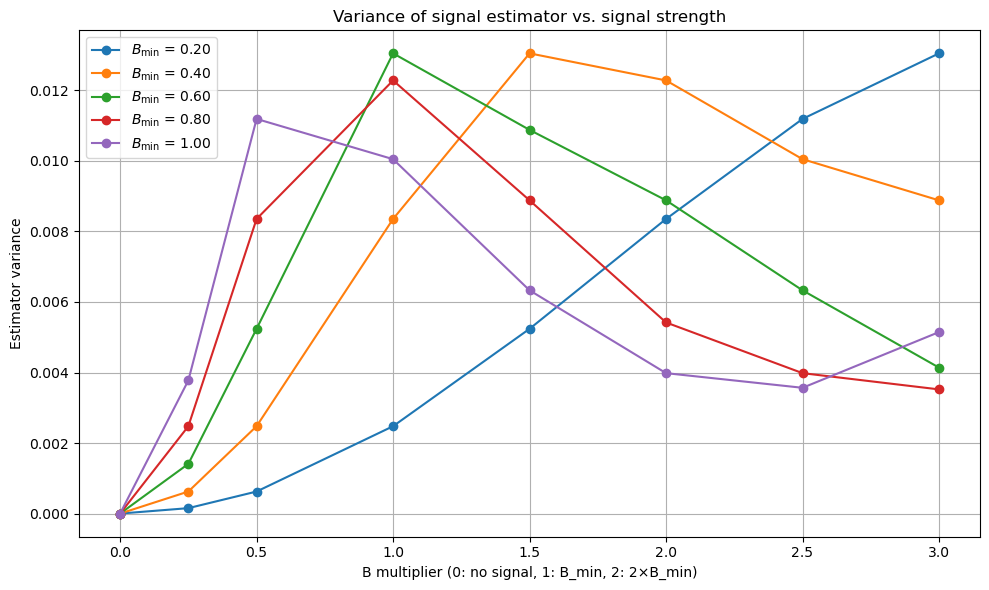

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# --- Simulation Parameters ---
T = 5.0
steps = 1000
times = np.linspace(0, T, steps)
g = 1.0

# Sweep parameters
delta_omega = [0.2, 0.4, 0.6, 0.8, 1.0]     # B_min values
omegas = np.linspace(0, 1, 15)             # signal frequencies
B_factors = [0,.25, 0.5, 1, 1.5, 2, 2.5, 3]     # multiples of B_min

# Qubit Operators
sx, sy, sz = sigmax(), sigmay(), sigmaz()
psi0 = (basis(2, 0) + basis(2, 1)).unit()

# Store estimation results
results = {}

# Estimate signal strength using both ⟨Z⟩ and ⟨X⟩ expectation values
def estimate_signal_strength(z_vals, x_vals, tvals):
    # Combine into "contrast" estimator (heuristic)
    contrast = np.std(z_vals) + np.std(x_vals)
    return contrast

# Simulation
for B_min in delta_omega:
    results[B_min] = {}
    for B_mult in B_factors:
        B = B_mult * B_min
        B_estimates = []

        for omega in omegas:
            # Define time-dependent Hamiltonian: H = gX + B cos(ωt)Z
            H = [g * sx, [sz, lambda t, args: B * np.cos(omega * t)]]
            result = mesolve(H, psi0, times, [], [sz, sx])
            z_vals = result.expect[0]
            x_vals = result.expect[1]

            est = estimate_signal_strength(z_vals, x_vals, times)
            B_estimates.append(est)

        avg_est = np.mean(B_estimates)
        var_est = np.var(B_estimates)
        results[B_min][B] = {"mean": avg_est, "var": var_est}

# --- Hypothesis Testing ---
print("\n--- Hypothesis Testing Results ---")
print("{:<10} {:<10} {:<10} {:<12} {:<12} {:<10} {:<10}".format(
    "B_min", "B", "B/B_min", "Var(Est)", "Threshold", "Decision", "Correct"
))

for B_min in delta_omega:
    baseline_var = results[B_min][0.0]["var"]
    # Apply fixed gap thresholding (for distinguishability)
    threshold = baseline_var + 0.001  # avoid numerical zero issue

    for B_mult in B_factors:
        B = B_mult * B_min
        var = results[B_min][B]["var"]
        decision = "H1" if var > threshold else "H0"
        correct = ((B_mult == 0 and decision == "H0") or
                   (B_mult >= 1.0 and decision == "H1"))

        print("{:<10.2f} {:<10.2f} {:<10.2f} {:<12.5f} {:<12.5f} {:<10} {:<10}".format(
            B_min, B, B_mult, var, threshold, decision, str(correct)
        ))

# --- Plotting: Estimator Variance ---
plt.figure(figsize=(10, 6))
for B_min in delta_omega:
    vars_ = [results[B_min][B_mult * B_min]["var"] for B_mult in B_factors]
    plt.plot(B_factors, vars_, marker='o', label=f'$B_{{\\min}}$ = {B_min:.2f}')
plt.xlabel("B multiplier (0: no signal, 1: B_min, 2: 2×B_min)")
plt.ylabel("Estimator variance")
plt.title("Variance of signal estimator vs. signal strength")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

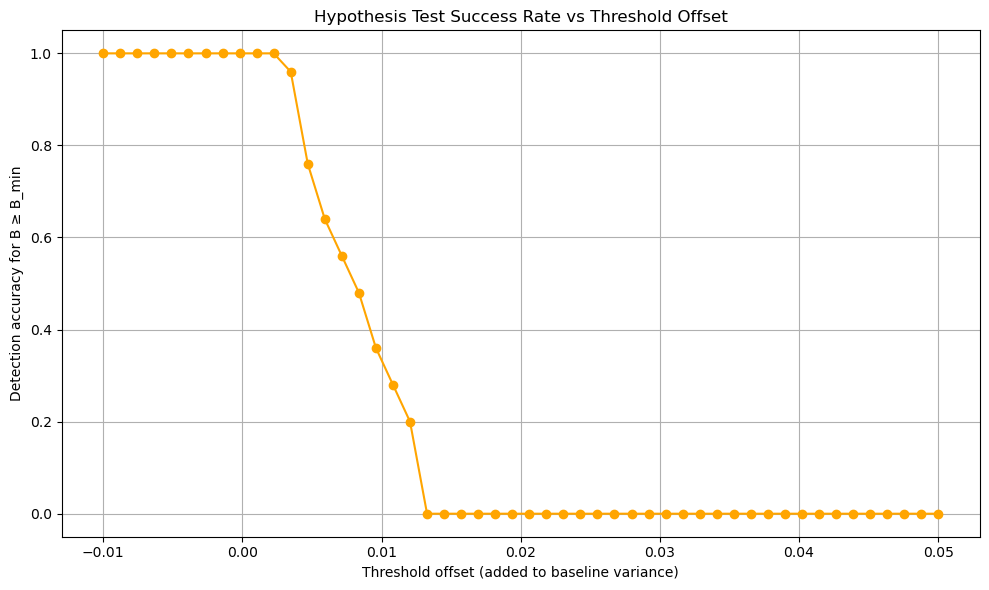

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Simulation parameters
T = 5.0
steps = 1000
times = np.linspace(0, T, steps)
g = 1.0

# Parameter sweeps
delta_omega = [0.2, 0.4, 0.6, 0.8, 1.0]
omegas = np.linspace(0, 1, 15)
B_factors = [0, 0.5, 1, 1.5, 2, 2.5, 3]

# Qubit operators and initial state
sx, sz = sigmax(), sigmaz()
psi0 = (basis(2, 0) + basis(2, 1)).unit()

# Use both ⟨Z⟩ and ⟨X⟩ to form a signal estimator
def estimate_signal_strength(z_vals, x_vals):
    return np.std(z_vals) + np.std(x_vals)

# Simulate and store estimator variances
results = {}
for B_min in delta_omega:
    results[B_min] = {}
    for B_mult in B_factors:
        B = B_mult * B_min
        estimates = []
        for omega in omegas:
            H = [g * sx, [sz, lambda t, args: B * np.cos(omega * t)]]
            result = mesolve(H, psi0, times, [], [sz, sx])
            z_vals, x_vals = result.expect[0], result.expect[1]
            est = estimate_signal_strength(z_vals, x_vals)
            estimates.append(est)
        avg, var = np.mean(estimates), np.var(estimates)
        results[B_min][B] = {"mean": avg, "var": var}

# Sweep over threshold offsets and test accuracy
threshold_offsets = np.linspace(-0.01, 0.05, 50)
threshold_scan_results = []

for offset in threshold_offsets:
    correct_total, total = 0, 0
    for B_min in delta_omega:
        baseline_var = results[B_min][0.0]["var"]
        threshold = baseline_var + offset
        for B_mult in B_factors:
            if B_mult < 1.0:
                continue  # promise case: only B ≥ B_min
            B = B_mult * B_min
            var = results[B_min][B]["var"]
            decision = "H1" if var > threshold else "H0"
            correct = (decision == "H1")  # truth is always H1
            correct_total += int(correct)
            total += 1
    accuracy = correct_total / total if total > 0 else 0
    threshold_scan_results.append((offset, accuracy))

# Plot results
thresholds, accuracies = zip(*threshold_scan_results)
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, marker='o', color='orange')
plt.xlabel("Threshold offset (added to baseline variance)")
plt.ylabel("Detection accuracy for B ≥ B_min")
plt.title("Hypothesis Test Success Rate vs Threshold Offset")
plt.grid(True)
plt.tight_layout()
plt.show()


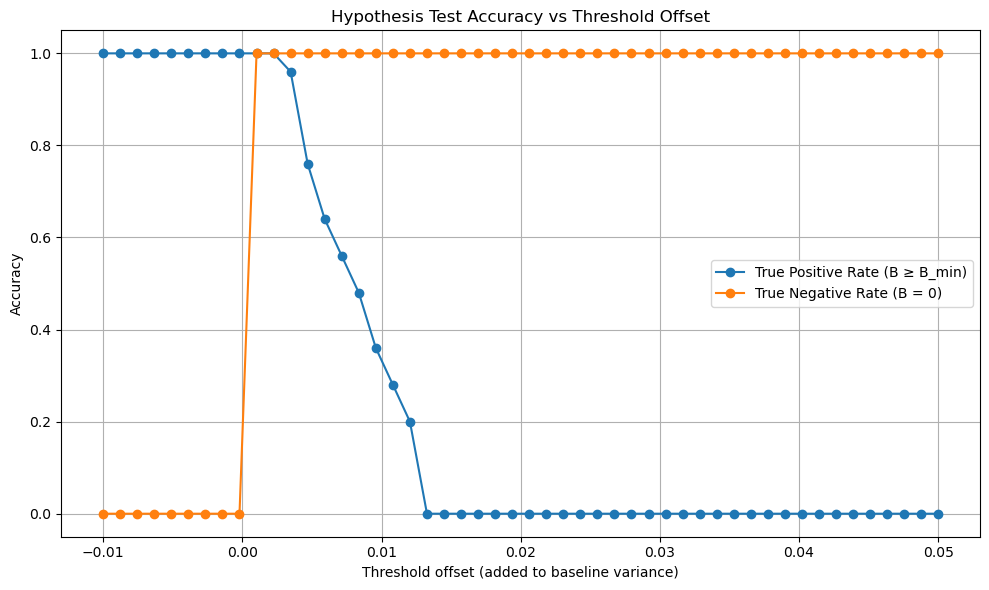

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Parameters
T = 5.0
steps = 1000
times = np.linspace(0, T, steps)
g = 1.0

delta_omega = [0.2, 0.4, 0.6, 0.8, 1.0]
omegas = np.linspace(0, 1, 15)
B_factors = [0, 0.5, 1, 1.5, 2, 2.5, 3]

sx, sz = sigmax(), sigmaz()
psi0 = (basis(2, 0) + basis(2, 1)).unit()

def estimate_signal_strength(z_vals, x_vals):
    return np.std(z_vals) + np.std(x_vals)

# Run simulation
results = {}
for B_min in delta_omega:
    results[B_min] = {}
    for B_mult in B_factors:
        B = B_mult * B_min
        estimates = []
        for omega in omegas:
            H = [g * sx, [sz, lambda t, args: B * np.cos(omega * t)]]
            result = mesolve(H, psi0, times, [], [sz, sx])
            z_vals, x_vals = result.expect[0], result.expect[1]
            est = estimate_signal_strength(z_vals, x_vals)
            estimates.append(est)
        avg, var = np.mean(estimates), np.var(estimates)
        results[B_min][B] = {"mean": avg, "var": var}

# Hypothesis testing across threshold offsets
threshold_offsets = np.linspace(-0.01, 0.05, 50)
true_positive_rates = []
true_negative_rates = []

for offset in threshold_offsets:
    tp, tn = 0, 0
    tp_total, tn_total = 0, 0

    for B_min in delta_omega:
        baseline_var = results[B_min][0.0]["var"]
        threshold = baseline_var + offset

        for B_mult in B_factors:
            B = B_mult * B_min
            var = results[B_min][B]["var"]
            decision = "H1" if var > threshold else "H0"

            if B_mult == 0:  # Null case
                tn_total += 1
                if decision == "H0":
                    tn += 1
            elif B_mult >= 1.0:  # Promise case
                tp_total += 1
                if decision == "H1":
                    tp += 1

    true_positive_rates.append(tp / tp_total if tp_total else 0)
    true_negative_rates.append(tn / tn_total if tn_total else 0)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(threshold_offsets, true_positive_rates, label="True Positive Rate (B ≥ B_min)", marker='o')
plt.plot(threshold_offsets, true_negative_rates, label="True Negative Rate (B = 0)", marker='o')
plt.xlabel("Threshold offset (added to baseline variance)")
plt.ylabel("Accuracy")
plt.title("Hypothesis Test Accuracy vs Threshold Offset")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


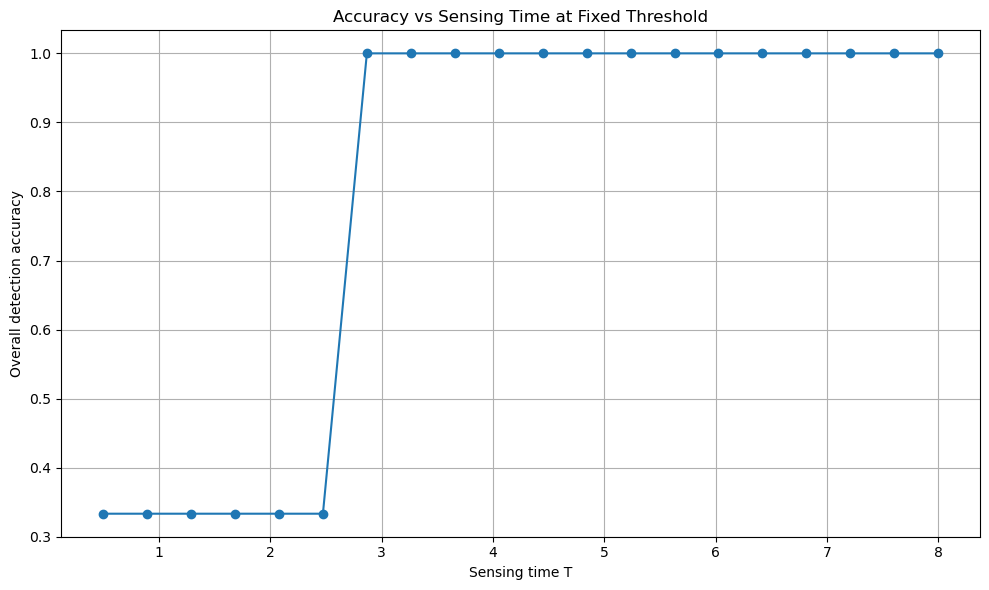

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Sweep parameters
T_values = np.linspace(0.5, 8.0, 20)  # range of sensing times to test
g = 1.0
delta_omega = [0.4]  # just pick one B_min to focus the sweep
B_factors = [0, 1.0, 2.0]  # test null and signal cases
omegas = np.linspace(0, 1, 15)

# Fixed threshold offset chosen from earlier eyeballing
fixed_threshold_offset = 0.01/8  # tweak this based on earlier plots

# Qubit setup
sx, sz = sigmax(), sigmaz()
psi0 = (basis(2, 0) + basis(2, 1)).unit()

def estimate_signal_strength(z_vals, x_vals):
    return np.std(z_vals) + np.std(x_vals)

# Track detection accuracy vs T
accuracies = []

for T in T_values:
    steps = 1000
    times = np.linspace(0, T, steps)
    correct, total = 0, 0

    for B_min in delta_omega:
        results = {}
        baseline_var = None

        for B_mult in B_factors:
            B = B_mult * B_min
            estimates = []

            for omega in omegas:
                H = [g * sx, [sz, lambda t, args: B * np.cos(omega * t)]]
                result = mesolve(H, psi0, times, [], [sz, sx])
                z_vals, x_vals = result.expect[0], result.expect[1]
                est = estimate_signal_strength(z_vals, x_vals)
                estimates.append(est)

            avg = np.mean(estimates)
            var = np.var(estimates)
            results[B] = {"mean": avg, "var": var}

            if B_mult == 0:
                baseline_var = var

        # Apply threshold test to B ≥ B_min
        threshold = baseline_var + fixed_threshold_offset
        for B_mult in B_factors:
            B = B_mult * B_min
            if B_mult == 0:
                expected = "H0"
            elif B_mult >= 1.0:
                expected = "H1"
            else:
                continue

            var = results[B]["var"]
            decision = "H1" if var > threshold else "H0"
            correct += int(decision == expected)
            total += 1

    accuracies.append(correct / total if total else 0)

# Plot the result
plt.figure(figsize=(10, 6))
plt.plot(T_values, accuracies, marker='o')
plt.xlabel("Sensing time T")
plt.ylabel("Overall detection accuracy")
plt.title("Accuracy vs Sensing Time at Fixed Threshold")
plt.grid(True)
plt.tight_layout()
plt.show()


 40%|█████████████████▌                          | 4/10 [00:19<00:28,  4.81s/it]

3.1666666666666665


 50%|██████████████████████                      | 5/10 [00:23<00:22,  4.41s/it]

3.0


 60%|██████████████████████████▍                 | 6/10 [00:26<00:16,  4.02s/it]

2.833333333333333


 70%|██████████████████████████████▊             | 7/10 [00:30<00:11,  3.76s/it]

2.833333333333333


 80%|███████████████████████████████████▏        | 8/10 [00:32<00:06,  3.42s/it]

2.6666666666666665


 90%|███████████████████████████████████████▌    | 9/10 [00:35<00:03,  3.18s/it]

2.6666666666666665


100%|███████████████████████████████████████████| 10/10 [00:38<00:00,  3.80s/it]

2.6666666666666665


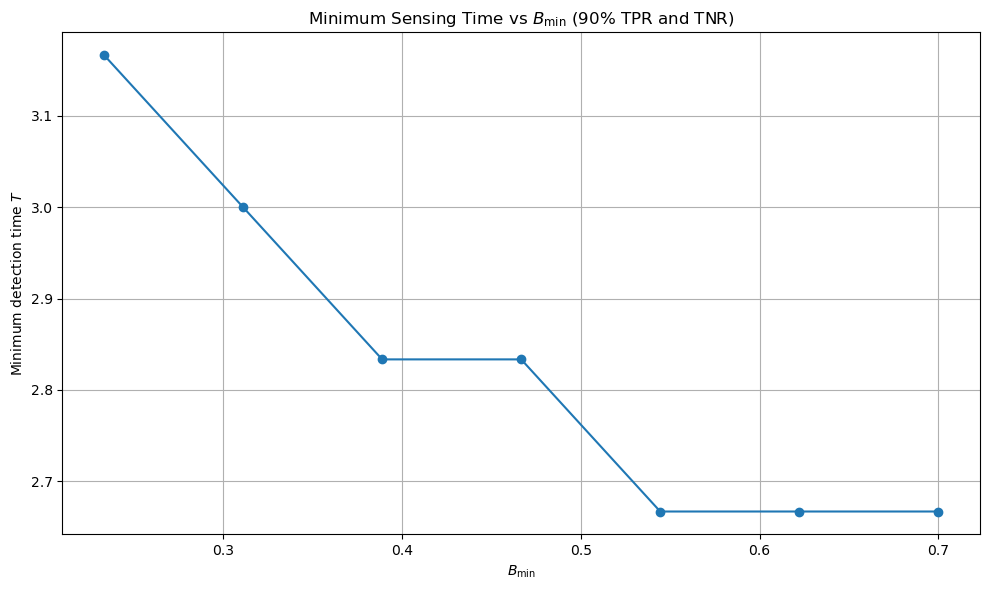

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm

# Parameters
B_min_values = np.linspace(0,.7, 10)
T_values = np.linspace(2, 3.5, 10)
g = 1.0
steps = 1000
omegas = np.linspace(0, 1, 10)
B_factors = [0, 1.0, 2.0]  # include null and signal cases

sx, sz = sigmax(), sigmaz()
psi0 = (basis(2, 0) + basis(2, 1)).unit()

def estimate_signal_strength(z_vals, x_vals):
    return np.std(z_vals) + np.std(x_vals)

# Output storage
min_time_for_B = []

# Loop over B_min values
for B_min in tqdm(B_min_values):
    success_T = None

    # Sweep time
    for T in T_values:
        times = np.linspace(0, T, steps)
        results = {}

        # Simulate for B = 0 and B = B_min, 2 B_min
        for B_mult in B_factors:
            B = B_mult * B_min
            estimates = []
            for omega in omegas:
                H = [g * sx, [sz, lambda t, args: B * np.cos(omega * t)]]
                result = mesolve(H, psi0, times, [], [sz, sx])
                z_vals, x_vals = result.expect[0], result.expect[1]
                est = estimate_signal_strength(z_vals, x_vals)
                estimates.append(est)
            results[B] = np.var(estimates)

        # Sweep threshold offsets
        baseline_var = results[0.0]
        threshold_offsets = np.linspace(-0.01, 0.1, 10)

        for offset in threshold_offsets:
            threshold = baseline_var + offset
            tp = tn = tp_total = tn_total = 0

            for B_mult in B_factors:
                B = B_mult * B_min
                var = results[B]
                decision = "H1" if var > threshold else "H0"
                if B_mult == 0:
                    tn_total += 1
                    if decision == "H0":
                        tn += 1
                elif B_mult >= 1.0:
                    tp_total += 1
                    if decision == "H1":
                        tp += 1

            tpr = tp / tp_total if tp_total else 0
            tnr = tn / tn_total if tn_total else 0
            if tpr >= 0.9 and tnr >= 0.9:
                success_T = T
                print(success_T)
                break  # No need to check more thresholds for this T

        if success_T:
            break  # Found minimum good T for this B_min

    min_time_for_B.append(success_T if success_T else np.nan)

# Plot time vs. B_min
plt.figure(figsize=(10, 6))
plt.plot(B_min_values, min_time_for_B, marker='o')
plt.xlabel("$B_{\\min}$")
plt.ylabel("Minimum detection time $T$")
plt.title("Minimum Sensing Time vs $B_{\\min}$ (90% TPR and TNR)")
plt.grid(True)
plt.tight_layout()
plt.show()


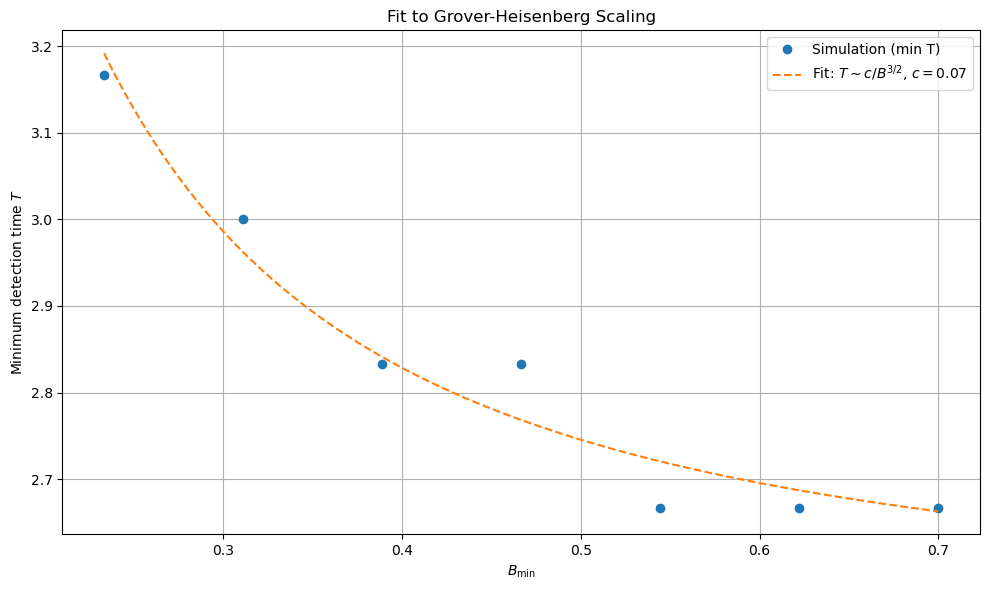

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Suppose these are your results:
# B_min_values = np.array([...])
# min_time_for_B = np.array([...])

# Example placeholders (replace with your data if needed)
# B_min_values = np.linspace(0.1, 1.0, 10)
# min_time_for_B = your_computed_min_times

# GHL model: T = c / B_min^{3/2}
def ghl_model(B_min, c, d):
    return c / (B_min)**1.5 + d

# Fit model to data
valid = ~np.isnan(min_time_for_B)
B_fit = B_min_values[valid]
T_fit = np.array(min_time_for_B)[valid]
params, _ = curve_fit(ghl_model, B_fit, T_fit)
c_fit = params[0]

# Generate smooth curve for plot
B_smooth = np.linspace(min(B_fit), max(B_fit), 200)
T_smooth = ghl_model(B_smooth, *params)

# Plot original data and fit
plt.figure(figsize=(10, 6))
plt.plot(B_min_values, min_time_for_B, 'o', label='Simulation (min T)')
plt.plot(B_smooth, T_smooth, '--', label=f'Fit: $T \\sim c / B^{{3/2}}$, $c={c_fit:.2f}$')
plt.xlabel('$B_{\\min}$')
plt.ylabel('Minimum detection time $T$')
plt.title('Fit to Grover-Heisenberg Scaling')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Simulation Parameters
T = 5.0
steps = 1000
times = np.linspace(0, T, steps)
g = 1.0
delta_omega = [0.2, 0.4, 0.6, 0.8, 1.0]
omegas = np.linspace(0, 1, 15)
B_factors = [0, 0.5, 1, 1.5, 2, 2.5, 3]

# Qubit setup
sx, sz = sigmax(), sigmaz()
psi0 = (basis(2, 0) + basis(2, 1)).unit()

def estimate_signal_strength(z_vals, x_vals):
    return np.std(z_vals) + np.std(x_vals)

# Run simulation
results = {}
for B_min in delta_omega:
    results[B_min] = {}
    for B_mult in B_factors:
        B = B_mult * B_min
        estimates = []
        for omega in omegas:
            H = [g * sx, [sz, lambda t, args: B * np.cos(omega * t)]]
            result = mesolve(H, psi0, times, [], [sz, sx])
            z_vals, x_vals = result.expect[0], result.expect[1]
            est = estimate_signal_strength(z_vals, x_vals)
            estimates.append(est)
        avg, var = np.mean(estimates), np.var(estimates)
        results[B_min][B] = {"mean": avg, "var": var}

# Threshold sweep
threshold_offsets = np.linspace(-0.01, 0.05, 50)
true_positive_rates = []
true_negative_rates = []
optimal_threshold = None

for offset in threshold_offsets:
    tp = tn = tp_total = tn_total = 0

    for B_min in delta_omega:
        baseline_var = results[B_min][0.0]["var"]
        threshold = baseline_var + offset

        for B_mult in B_factors:
            B = B_mult * B_min
            var = results[B_min][B]["var"]
            decision = "H1" if var > threshold else "H0"

            if B_mult == 0:
                tn_total += 1
                if decision == "H0":
                    tn += 1
            elif B_mult >= 1.0:
                tp_total += 1
                if decision == "H1":
                    tp += 1

    tpr = tp / tp_total if tp_total else 0
    tnr = tn / tn_total if tn_total else 0
    true_positive_rates.append(tpr)
    true_negative_rates.append(tnr)

    if optimal_threshold is None and tpr >= 0.9 and tnr >= 0.9:
        optimal_threshold = offset

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(threshold_offsets, true_positive_rates, label="True Positive Rate (B ≥ B_min)", marker='o')
plt.plot(threshold_offsets, true_negative_rates, label="True Negative Rate (B = 0)", marker='o')
if optimal_threshold is not None:
    plt.axvline(optimal_threshold, color='gray', linestyle='--', label=f"Optimal threshold = {optimal_threshold:.3f}")
plt.xlabel("Threshold offset (added to baseline variance)")
plt.ylabel("Accuracy")
plt.title("Hypothesis Test Accuracy vs Threshold Offset")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

if optimal_threshold is not None:
    print(f"✅ Optimal threshold offset: {optimal_threshold:.5f}")
else:
    print("❌ No threshold found where both TPR and TNR ≥ 90%")
